# Sprint20 セグメンテーション２
# 【問題１】コードレビュー
以下のコードのU-Netに当たる部分（５．トレーニング用U-Netモデルを定義）をコードレビューします．

## Keras - Clean Project Workflow


### Aim:


Aim of this notebook is to show an example of clean workflow Computer Vision project/competition in Keras. 

### Workflow:


Workflow can be interpreted as following steps:
1. Dataset initialization (if needed): this step is usually required in case where training samples are separated from from their labels or there is additional information about the samples of a different format. This is the case here, __depth__ is an additional feature that is separate from training images and is thus provided in DataFrame format. For easy integration between the depth and images, each sample has a unique ID. By those IDs images can be connected with their masks and depth added on top of that.
2. Data loading/processing: set of operations preparing the data for model-ingestible format. Each sample is loaded as image and appended to a list, same happends with masks. Afterwards, dimensions are expanded (if needed), because 2D Convolutional CNN require input samples of dimensionality (HxWxC - height x width x channels) and OpenCV loads grayscale images as (HxW) 2D arrays.
3. Data is normalized to 0-1 input range. When loaded in OpenCV, grayscale images come in range between 0 and 255. Networks usually converge quicker if data is in 0-1 range. It is also important to keep the values range the same for images and masks (feeding the model with 0-255 images and 0-1 masks is not recommended).
4. Data is split into training and validation subsets. For this competition, salt coverage is the basis of the split. Then, a stratified split is performed in order to avoid significant discrepancy in distribution between training and validation sets. This could potentially harm model performance or at least skew the validation metric results.
5. Model definition and training. A lot more about this can be read either in segmentation papers, solutions from past competition or discussions part itself :). One major principle to keep in mind - segmentation model output must be of the same shape as was the input! 
6. Prediction with trained model.
7. Predictions processing. This can be done in different ways, depending on the final goal. For this competition, predictions and encoded with Run Length Encoding in order to compress their size (raw masks predictions would weight around a GB). Method of processing is very important, as it may require a specific approach to final predictions preparation. In case of RLE, one have to make sure that predictions are scaled (or unpadded) to original image size. Otherwise, RLE will encode wrong pixels and thus final submission score will be low. 

# Keras - Clean Project Workflow
### 目的：
このノートブックの目的は、KerasでのクリーンなワークフローComputer Visionプロジェクト/競争の例を示すことです。
## ワークフロー：
ワークフローは、次の手順として解釈できます。                                
#### 1.データセットの初期化（必要な場合）：
このステップは通常、トレーニングサンプルがラベルから分離されている場合、または異なる形式のサンプルに関する追加情報がある場合に必要です。この場合、__ depth__はトレーニング画像とは別の追加機能であるため、DataFrame形式で提供されます。深度と画像を簡単に統合するために、各サンプルには一意のIDがあります。これらのIDにより、画像はマスクとその上に追加された深度で接続できます。   
##### 2.データのロード/処理：
モデルで取り込み可能な形式のデータを準備する一連の操作。各サンプルは画像としてロードされ、リストに追加されます。マスクで同じことが起こります。その後、2D畳み込みCNNは次元の入力サンプル（HxWxC-高さx幅xチャンネル）を必要とし、OpenCVはグレースケール画像を（HxW）2D配列としてロードするため、次元は拡張されます（必要な場合）。                                    
#### 3.データは、0-1入力範囲に正規化されます。
OpenCVに読み込まれると、グレースケール画像の範囲は0〜255になります。データが0〜1の範囲にある場合、ネットワークは通常より速く収束します。画像とマスクの値の範囲を同じにすることも重要です（モデルに0〜255の画像と0〜1のマスクを供給することはお勧めしません）。                                                             
#### 4.データは、トレーニングと検証のサブセットに分割されます。
このコンペティションでは、ソルトカバレッジがスプリットの基礎となります。次に、トレーニングセットと検証セットの間の分布の大きな不一致を回避するために、階層化された分割が実行されます。これにより、モデルのパフォーマンスが低下したり、少なくとも検証メトリックの結果が歪んだりする可能性があります。                               
#### 5.モデルの定義とトレーニング。
これについての詳細は、セグメンテーションペーパー、過去の競合からのソリューション、または議論自体で読むことができます:)。念頭に置いておくべき1つの主要な原則-セグメンテーションモデルの出力は、入力と同じ形状でなければなりません！
#### 6.訓練されたモデルによる予測。                                       
7.予測処理。これは、最終目標に応じて、さまざまな方法で実行できます。この競争では、予測を実行し、サイズを圧縮するためにRun Length Encodingでエンコードされます（rawマスクの予測は約1 GBになります）。最終的な予測の準備に特定のアプローチが必要になる場合があるため、処理方法は非常に重要です。 RLEの場合、予測が元の画像サイズに合わせてスケーリングされる（またはパディングされない）ことを確認する必要があります。そうしないと、RLEが間違ったピクセルをエンコードするため、最終的な提出スコアが低くなります。

# メモ
### np.expand_dims(self.X_train, -1)
* np.expand_dims(行列, axis=)
* np.newaxisと基本的には同じ動き．指定したaxis方向に次元を増やす
* np.expand_dims(self.X_train, -1)のように「-1」とすると，flattenになると思う．

In [ ]:
import gc
import glob
import os
import matplotlib.pyplot as plt

import cv2
import numpy as np
import pandas as pd

from keras.callbacks import *
from keras.models import load_model
#走らせた処理の進捗状況をプログレスバーとして表示する
from tqdm import tqdm

from sklearn.model_selection import train_test_split

%matplotlib inline

plt.rcParams['figure.figsize'] = (12, 9)
plt.style.use('ggplot')

## Define SaltParser

The first question most probably would be - __why create and use parser like this one?__

In Machine Learning, you usually can tune two things: models and data. Each parameter can influence the final score, so it's good to know what kind of parameters are used for each run and it's even better to design the pipeline in a way that will minimize potential errors. 

When a certain operation will be used many times but with different parameters, it is good to parameterize it and just call with chosen parameters. Besides, having functions for processing in one place makes it easier to spot mistakes. This is even more important when you perform an operation in different parts of the pipeline. Then, making sure that all functions are doing the same (for example using different types of padding for training and prediction certainly would not be a good idea!).

## Define SaltParser
最初の質問はおそらく**「なぜこのようなパーサーを作成して使用するのでしょうか？」**                            
機械学習では、通常、モデルとデータの2つのことを調整できます。 各パラメーターは最終スコアに影響を与える可能性があるため、実行ごとにどのようなパラメーターが使用されているかを知っておくとよいでしょう。
### pipe line
* 潜在的なエラーを最小限に抑える方法でパイプラインを設計することをお勧めします。
* 特定の操作が何度も使用され、パラメーターが異なる場合は、それをパラメーター化して、選択したパラメーターを使用して呼び出すことをお勧めします。 
* また、1つの場所で処理する機能があると、間違いを見つけやすくなります。 パイプラインのさまざまな部分で操作を実行する場合、これはさらに重要です。 そして、すべての機能が同じことをしていることを確認してください（たとえば、トレーニングと予測に異なるタイプのパディングを使用することは、確かに良い考えではありません！）。

In [ ]:
class SaltParser(object):

    """
    Parser for Salt Competition.
    """

    def __init__(self,
                 data_src='../input/',
                 image_size=(128, 128),
                 pad_images=False,
                 grayscale=True,
                 load_test_data=True):

        self.data_src = data_src
        self.image_size = image_size
        self.pad_images = pad_images
        self.grayscale = grayscale
        self.load_test_data = load_test_data

        self.train_df = None
        self.test_df = None
        self.padding_pixels = None

        self.X_train = []
        self.y_train = []
        self.X_test = []

        self.orig_image_size = (101, 101)
        
        """
        # Arguments:
        
            data_src: directory containing data
            image_size: tuple specifying final image size
            pad_images: whether images should be padded or resized
            grayscale: whether to load images as grayscale
            load_test_data: whether to load test data
            
        """

    def initialize_data(self):
        
        """
        Initialize processing by loading .csv files.
        """

        train_df = pd.read_csv('{}train.csv'.format(self.data_src),
                               usecols=[0], index_col='id')
        depths_df = pd.read_csv('{}depths.csv'.format(self.data_src),
                                index_col='id')

        self.train_df = train_df.join(depths_df)
        self.test_df = depths_df[~depths_df.index.isin(train_df.index)]

        return

    def load_data(self):
        
        """
        Load images and masks from training set.
        
        # Returns:
            self.X_train: np.array of training images
            self.y_train: np.array of training masks
            self.X_test: np.array of test images
        """

        print('Loading training set.')
        # Loop over ids in train_df
        for i in tqdm(self.train_df.index):
            # Load image and mask according to ID
            img_src = '{}train/images/{}.png'.format(self.data_src, i)
            mask_src = '{}train/masks/{}.png'.format(self.data_src, i)
            # Specify if image should be loaded in grayscale.
            if self.grayscale:
                img_temp = cv2.imread(img_src, 0)
            else:
                img_temp = cv2.imread(img_src)
            # Load mask
            mask_temp = cv2.imread(mask_src, 0)
            # Resize or pad image and mask
            if self.orig_image_size != self.image_size:
                if self.pad_images:
                    img_temp = self.__pad_image(img_temp)
                    mask_temp = self.__pad_image(mask_temp)
                else:
                    img_temp = cv2.resize(img_temp, self.image_size)
                    mask_temp = cv2.resize(mask_temp, self.image_size)
            # Append processed image and mask
            self.X_train.append(img_temp)
            self.y_train.append(mask_temp)

        # Transform into arrays
        self.X_train = np.asarray(self.X_train)
        self.y_train = np.asarray(self.y_train)
        # If images were loaded as grayscale, they are loaded as (HxW) arrays
        # Dimensions must be expanded for the model to be trained.
        if self.grayscale:
            self.X_train = np.expand_dims(self.X_train, -1)
        # Mask must be expanded obligatorily, as they are 1-channel by default.
        self.y_train = np.expand_dims(self.y_train, -1)

        # Output information about training set.
        print('Training set ready.')
        print('X_train shape: {}'.format(self.X_train.shape))
        print('y_train shape: {}'.format(self.y_train.shape))
        print('X_train - min: {}, max: {}'.format(
            np.min(self.X_train), np.max(self.X_train)))
        print('y_train - min: {}, max: {}'.format(
            np.min(self.y_train), np.max(self.y_train)))

        # Load test data.
        # Perform similar steps to the training processing part,
        # but there are no masks to be loaded.
        if self.load_test_data:
            print('Loading test set.')
            for i in tqdm(self.test_df.index):
                img_src = '{}test/images/{}.png'.format(self.data_src, i)
                if self.grayscale:
                    img_temp = cv2.imread(img_src, 0)
                else:
                    img_temp = cv2.imread(img_src)
                if self.orig_image_size != self.image_size:
                    if self.pad_images:
                        img_temp = self.__pad_image(img_temp)
                    else:
                        img_temp = cv2.resize(img_temp, self.image_size)
                self.X_test.append(img_temp)

            self.X_test = np.asarray(self.X_test)
            if self.grayscale:
                self.X_test = np.expand_dims(self.X_test, -1)

            print('Test set ready.')
            print('X_test shape: {}'.format(self.X_test.shape))
            print('X_test - min: {}, max: {}'.format(
                np.min(self.X_test), np.max(self.X_test)))

            return self.X_train, self.y_train, self.X_test

        return self.X_train, self.y_train

    def compute_coverage(self):
        
        """
        Compute salt coverage of each mask. This will serve as a basis for 
        stratified split between training and validation sets.
        
        # Returns:
            self.train_df: training DF containing coverage information.
        """

        print('Compute mask coverage for each observation.')

        def cov_to_class(val):
            for i in range(0, 11):
                if val * 10 <= i:
                    return i

        # Output percentage of area covered by class
        self.train_df['coverage'] = np.mean(self.y_train / 255., axis=(1, 2))
        # Coverage must be split into bins, otherwise stratified split will not be possible,
        # because each coverage will occur only once.
        self.train_df['coverage_class'] = self.train_df.coverage.map(
            cov_to_class)

        return self.train_df

    def predictions_rle_encode(self,
                               y_pred_test,
                               confidence_threshold_best):
        
        """
        Run Length Encoding of predictions.
        This is needed for submission output.
        
        # Arguments:
            y_pred_test: model predictions
            confidence_threshold_best: confidence threshold, according to which
                masks are set to 1/0.
        # Returns:
            y_test_pred_rle: RLEncoded predictions.
        """

        # If images were padded, this padding must now be removed.
        # Otherwise encoding method will fail to properly encode predictions and
        # score will be bad.
        if self.pad_images:
            print('Remove padding from images.')
            y_min_pad, y_max_pad, x_min_pad, x_max_pad = self.padding_pixels[
                0], self.padding_pixels[1], self.padding_pixels[2], self.padding_pixels[3]
            y_pred_test = y_pred_test[:, y_min_pad:-
                                      y_max_pad, x_min_pad:-x_max_pad, 0]
            
        # Situation is similar for previously resized images.
        # They must be resized again to their original size before encoding.
        else:
            y_pred_test = np.asarray([cv2.resize(x, self.orig_image_size)
                                      for x in y_pred_test])

        assert y_pred_test.shape == (18000, 101, 101), '\
        Test predictions shape must be equal to (18000, 101, 101).'

        print('Test predictions shape: {}'.format(y_pred_test.shape))

        # Perform mask predictions binarization and RLEncoding. 
        y_test_pred_rle = {idx:
                           rle_encode(y_pred_test[i] > confidence_threshold_best)
                           for i, idx in enumerate(
                               tqdm(self.test_df.index.values))}

        return y_test_pred_rle

    def generate_submission(self, y_test_pred_rle):
        
        """
        Submission generation based on encoded model predictions.
        
        # Arguments:
            y_test_pred_rle: RLEncoded predictions.
        # Returns:
            submission: generated submission.
        """

        submission = pd.DataFrame.from_dict(y_test_pred_rle, orient='index')
        submission.index.names = ['id']
        submission.columns = ['rle_mask']

        return submission

    def return_padding_borders(self):
        """
        Return padding borders in case intermediate operations on original images
        are needed.
        
        # Returns:
            self.padding_pixels: tuple of padding borders.
        """
        return self.padding_pixels

    def __pad_image(self, img):
        
        """
        Helper function for images padding.
        
        # Arguments:
            img: image as np.array
            
        # Returns:
            img: padded image as np.array
        """

        pad_floor = np.floor(
            (np.asarray(self.image_size) - np.asarray(self.orig_image_size)) / 2)
        pad_ceil = np.ceil((np.asarray(self.image_size) -
                            np.asarray(self.orig_image_size)) / 2)

        self.padding_pixels = np.asarray(
            (pad_floor[0], pad_ceil[0], pad_floor[1], pad_ceil[1])).astype(np.int32)

        y_min_pad, y_max_pad, x_min_pad, x_max_pad = self.padding_pixels[
            0], self.padding_pixels[1], self.padding_pixels[2], self.padding_pixels[3]

        img = cv2.copyMakeBorder(img, y_min_pad, y_max_pad,
                                 x_min_pad, x_max_pad,
                                 cv2.BORDER_REFLECT_101)

        assert img.shape[:2] == self.image_size, '\
        Image after padding must have the same shape as input image.'

        return img

### Define helper functions:

In [ ]:
# Quick RLEncoding needed for submission generation.
# Source: another kernel, thanks!
def rle_encode(im):
    pixels = im.flatten(order='F')
    pixels = np.concatenate([[0], pixels, [0]])
    runs = np.where(pixels[1:] != pixels[:-1])[0] + 1
    runs[1::2] -= runs[::2]
    return ' '.join(str(x) for x in runs)

## 1. Initialize parameters:

In [ ]:
# Input dictionary for SaltParser
salt_parameters = {
    'data_src': '../input/',
    'image_size': (128, 128),
    'pad_images': False,
    'grayscale': False,
}

salt_parser = SaltParser(**salt_parameters)

normalize = True
save = False


# Automatic input_dim parameter specification
# for model training.
input_dim = salt_parameters['image_size']

if salt_parameters['grayscale']:
    input_dim = input_dim + (1,)
else:
    input_dim = input_dim + (3,)
    
# Run name
run_name = '{}_grayscale{}_pad{}_size{}'.format(
    'Unet',
    int(salt_parameters['grayscale']),
    int(salt_parameters['pad_images']),
    input_dim[0])

print('Run name: {}'.format(run_name))

## 2. Initialize and load data - call SaltParser functions:
   
1. Initialize data.
2. Load train and test set.
3. Compute coverage for stratified split.
4. Return padding pixels.

In [ ]:
salt_parser.initialize_data()
X_train, y_train, X_test = salt_parser.load_data()
train_df = salt_parser.compute_coverage()
padding_pixels = salt_parser.return_padding_borders()

## 3. Normalize input data to 0-1 range

In [ ]:
if normalize:
    # X_train, X_test = utils.normalize_along_channel(X_train, X_test)
    X_train = X_train / 255.
    y_train = y_train / 255.
    X_test = X_test / 255.
    print('X_train - min: {}, max: {}'.format(np.min(X_train), np.max(X_train)))
    print('y_train - min: {}, max: {}'.format(np.min(y_train), np.max(y_train)))
    print('Train set: {}, {}'.format(X_train.shape, y_train.shape))
    print('X_test - min: {}, max: {}'.format(np.min(X_test), np.max(X_test)))
    print('Test set: {}'.format(X_test.shape))
    
X_train = X_train.astype(np.float32)
y_train = y_train.astype(np.float32)
X_test = X_test.astype(np.float32)

## 4. Perform stratified training/validation split based on coverage.

In [ ]:
# Perform 80/20 training/validation split based on stratified coverage.
X_tr, X_val, y_tr, y_val, cov_train, cov_test, depth_train, depth_test = train_test_split(
    X_train,
    y_train,
    train_df.coverage.values,
    train_df.z.values,
    test_size=0.2, stratify=train_df.coverage_class, random_state=1234)


del train_df
gc.collect()

del X_train, y_train
gc.collect()

## 5. トレーニング用のU-Netモデルを定義
### Conv2DTranspose : デコンボリューション
keras.layers.Conv2DTranspose(filters, kernel_size, strides=(1, 1), padding='valid', output_padding=None, data_format=None, dilation_rate=(1, 1), activation=None, use_bias=True, kernel_initializer='glorot_uniform', bias_initializer='zeros', kernel_regularizer=None, bias_regularizer=None, activity_regularizer=None, kernel_constraint=None, bias_constraint=None)                              
普通の畳み込みの反対みたいなことをしてくれる
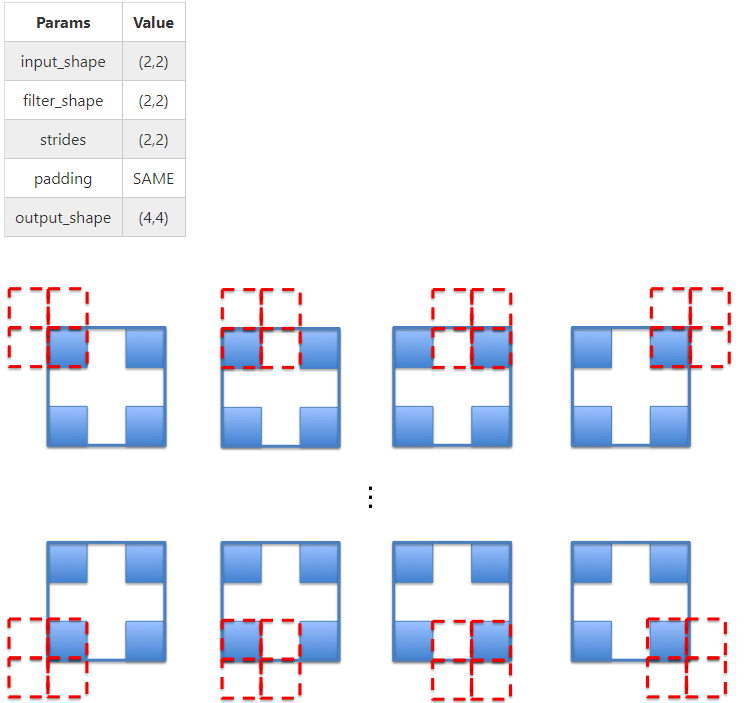

# 【問題1】コードレビュー
U-Netを再帰的に書いている部分を見ました．

In [ ]:
from keras import Model
from keras.layers import (Activation, BatchNormalization, Concatenate, Conv2D,
                          Conv2DTranspose, Dropout, Input, MaxPooling2D,
                          UpSampling2D, concatenate)
from keras.optimizers import Adam

#畳み込み層
def conv_block(m, dim, acti, bn, res, do=0):
    n = Conv2D(dim, 3, activation=acti, padding='same')(m)#畳み込み１
    n = BatchNormalization()(n) if bn else n#バッチノーマライズ
    n = Dropout(do)(n) if do else n#ドロップアウト
    n = Conv2D(dim, 3, activation=acti, padding='same')(n)#畳み込み２
    n = BatchNormalization()(n) if bn else n#
    return Concatenate()([m, n]) if res else n

#再帰的に呼び出し，「U-Net」構造を作る
def level_block(m, dim, depth, inc, acti, do, bn, mp, up, res):
    """m   : input
       dim : フィルタ枚数（=output_channels）
       depth:この値に達するまで，
       inc : 
       acti: activation
       do  : Dropoutする割合
       bn  : バッチノーマライズするか，しないか
       mp  : maxpooligするかしないか
       up  : アップサンプリングすかしないか
       res : ResNetならConcatenate
       
        """
    # depthに指定した深さのU-Net構造を作成
    if depth > 0:
        #エンコード
        n = conv_block(m, dim, acti, bn, res)#畳み込み→BatchNormalization→Dropout→畳み込み→BatchNormalization→（Concatenate）
        m = MaxPooling2D()(n) if mp else Conv2D(dim, 3, strides=2, padding='same')(n)#pooling
        m = level_block(m, int(inc * dim), depth - 1,#自分自身を呼び出す
                        inc, acti, do, bn, mp, up, res)
        
        # デコード
        if up: #（Trueなら）アップサンプリング．
            m = UpSampling2D()(m)
            m = Conv2D(dim, 2, activation=acti, padding='same')(m)# mのshapeは（w*2,H*2,channelはinputと変わらない）
        
        else:# （Falseなら）デコンボリューション
            m = Conv2DTranspose(dim, 3, strides=2,
                                activation=acti, padding='same')(m)# mのshapeは（w*2,H*2,channelはinputと変わらない）
        
        #エンコードで得られた特徴量とアップサンプリングした特徴量を結合
        n = Concatenate()([n, m])# nのshape（W, H, channelはn_channel + m_n_channel）
        # 畳み込んでサイズをもとに戻していく
        m = conv_block(n, dim, acti, bn, res)
    
    # depthが０になったら次の処理
    else:
        m = conv_block(m, dim, acti, bn, res, do)
    return m


def UNet(params):

    img_shape = params['input_dim']
    out_ch = 1
    start_ch = 8
    depth = 3
    inc_rate = 2.
    activation = 'relu'
    dropout = 0.5
    batchnorm = False
    maxpool = True
    upconv = True
    residual = False

    i = Input(shape=img_shape)
    o = level_block(i, start_ch, depth, inc_rate, activation,
                    dropout, batchnorm, maxpool, upconv, residual)
    o = Conv2D(out_ch, 1)(o)
    # Sigmoid activation is used because model is trained with binary_crossentropy.
    o =  Activation('sigmoid')(o)

    model = Model(inputs=i, outputs=o)
    
    return model

## 6. Train model:

In [ ]:
model = UNet({'input_dim': input_dim})
model.compile(optimizer='adam', loss='binary_crossentropy')


early_stopping = EarlyStopping(monitor='val_loss' ,patience=12, verbose=1, mode='min')
model_checkpoint = ModelCheckpoint("./{}.h5".format(run_name),monitor='val_loss',
                                   save_best_only=True, verbose=1, mode='min')
reduce_lr = ReduceLROnPlateau(
    monitor='val_loss',factor=0.33, patience=6, min_lr=1e-6, verbose=1, mode='min')

epochs = 10  # change to more for better score!
batch_size = 32


history = model.fit(X_tr, y_tr,
                    validation_data=[X_val, y_val], 
                    epochs=epochs,
                    batch_size=batch_size,
                    callbacks=[early_stopping, model_checkpoint, reduce_lr], 
                    verbose=1)

## 7. Predict validation and test set masks:

In [ ]:
y_pred_valid = model.predict(X_val)
y_pred_test = model.predict(X_test)

del X_tr, X_val, X_test
gc.collect()

In [ ]:
# Assume 0.5 threshold for mask binarization.
# This can be optimized!
y_pred_test_rle = salt_parser.predictions_rle_encode(
    y_pred_test, confidence_threshold_best=0.5)

submission = salt_parser.generate_submission(y_pred_test_rle)

# Save submission with specified run_name.
if save:
    submission.to_csv('submission_{}.csv'.format(run_name))
    
submission